# CNN Visualization

In [1]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

path = '../../../'

train_dataset = datasets.MNIST(root=path, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=path, train=False, download=True, transform=transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.features = nn.ModuleDict({
            'conv1' : nn.Conv2d(1, 32, kernel_size=3, stride = 1, padding=1),
            'pool1' : nn.MaxPool2d(kernel_size=2, stride=2),
            'conv2' : nn.Conv2d(32, 64, kernel_size=3, stride = 1, padding=1),
            'pool2' : nn.MaxPool2d(kernel_size=2, stride=2)
        })

        self.classifier = nn.ModuleDict({
            'fc1' : nn.Linear(64 * 7 * 7, 100),
            'dropout' : nn.Dropout(p = 0.4),
            'fc2' : nn.Linear(100, 10),
        })        
        
    def forward(self, x):
        for layer in self.features.values():
            x = layer(x)
        x = x.reshape(-1, 64*7*7)    
        for layer in self.classifier.values():
            x = layer(x)
        return x

## Model Load 후 conv1 visualization

In [4]:
model = CNN().to(device)
checkpoint = torch.load('CNN_save.pth')
model.load_state_dict(checkpoint)

model.eval()
with torch.no_grad():
    conv1_weights = model.features['conv1'].to('cpu').weight.detach().numpy()
conv1_weights.shape

(32, 1, 3, 3)

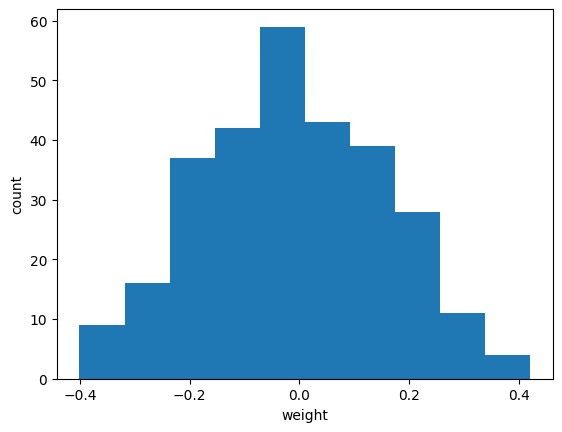

In [5]:
import matplotlib.pyplot as plt

plt.hist(conv1_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

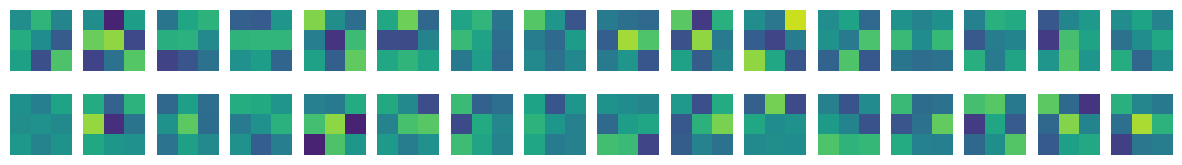

In [6]:
fig, axs = plt.subplots(2, 16, figsize=(15,2))

for i in range(2):
    for j in range(16):
        axs[i, j].imshow(conv1_weights[i*16 + j, 0, :, :], vmin=-0.5, vmax=0.5)
        axs[i, j].axis('off')

plt.show()

### 임의 모델과 비교

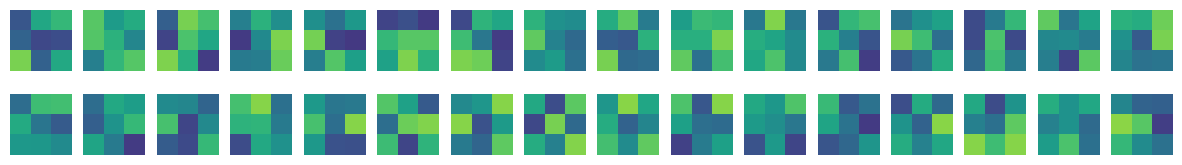

In [7]:
no_train_model = CNN()
no_train_weights = no_train_model.features['conv1'].weight.detach().numpy()

fig, axs = plt.subplots(2, 16, figsize=(15,2))
for i in range(2):
    for j in range(16):
        axs[i, j].imshow(no_train_weights[i*16 + j, 0, :, :], vmin=-0.5, vmax=0.5)
        axs[i, j].axis('off')

plt.show()

## Feature Map Visualization

### class 자체에서 feature_maps 반환하도록

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.ModuleDict({
            'conv1': nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            'pool1': nn.MaxPool2d(kernel_size=2, stride=2),
            'conv2': nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            'pool2': nn.MaxPool2d(kernel_size=2, stride=2)
        })
        self.classifier = nn.ModuleDict({
            'fc1': nn.Linear(64 * 7 * 7, 100),
            'dropout': nn.Dropout(p=0.4),
            'fc2': nn.Linear(100, 10),
        })

    def forward(self, x):
        feature_maps = []
        for layer in self.features.values():
            x = layer(x)
            feature_maps.append(x)  # 중간 출력을 리스트에 저장
        x = x.reshape(-1, 64 * 7 * 7)
        for layer in self.classifier.values():
            x = layer(x)
        return x, feature_maps

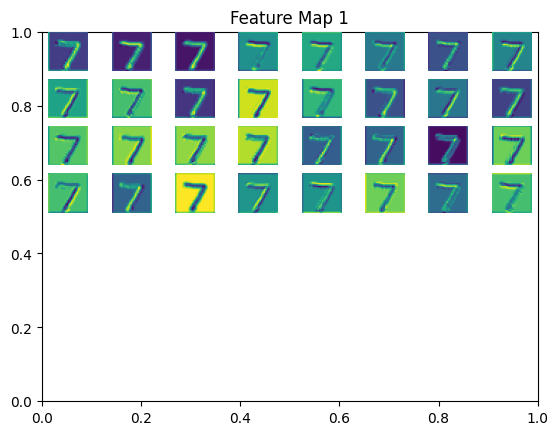

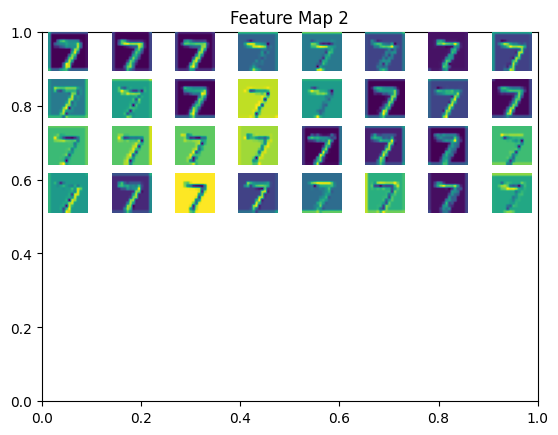

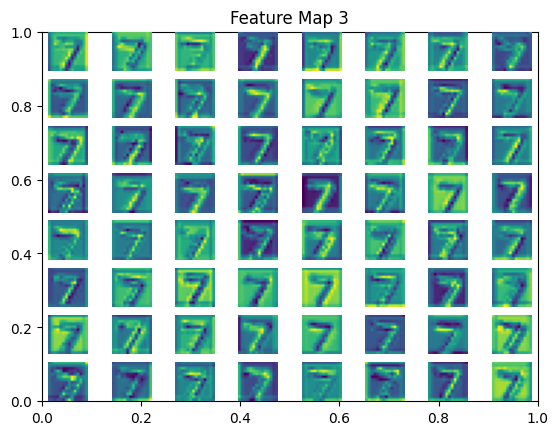

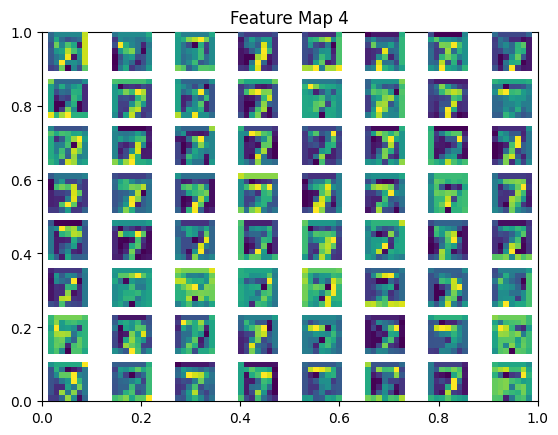

In [9]:
images, labels = next(iter(test_loader))
images = images.to(device)
model = CNN().to(device)

# 추론 모드로 설정
model.eval()

# 입력 이미지에 대한 예측과 중간 출력(feature maps) 얻기
with torch.no_grad():
    predictions, feature_maps = model(images)

# 중간 출력(feature maps) 시각화
for i, feature_map in enumerate(feature_maps):
    # plt.figure(figsize=(8, 8))
    plt.title(f"Feature Map {i + 1}")
    for j in range(feature_map.size(1)):
        plt.subplot(8, 8, j + 1)
        plt.imshow(feature_map[0, j].to('cpu').numpy())
        plt.axis('off')
    plt.show()

### 필요할 때만 feature_maps 반환하도록

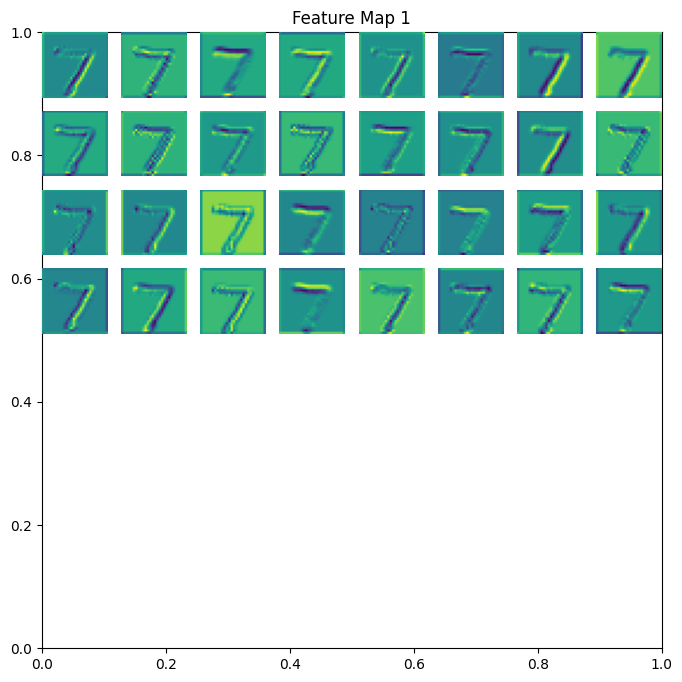

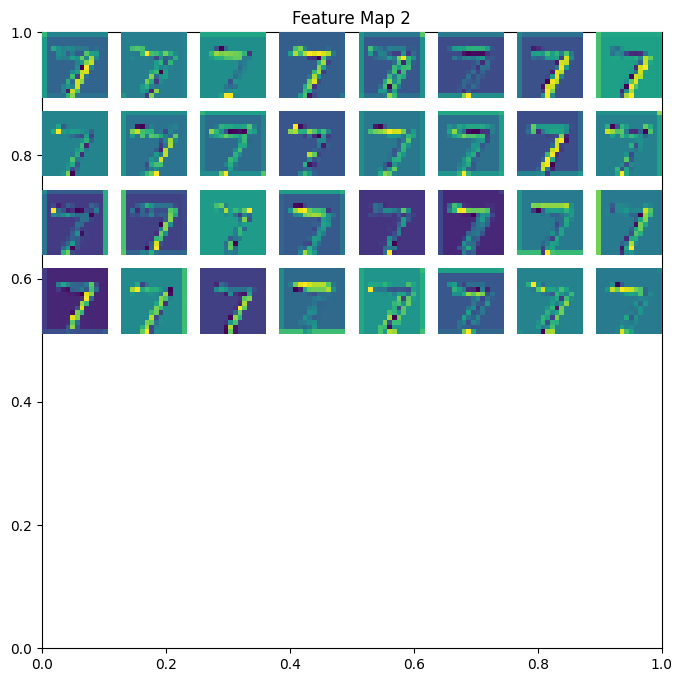

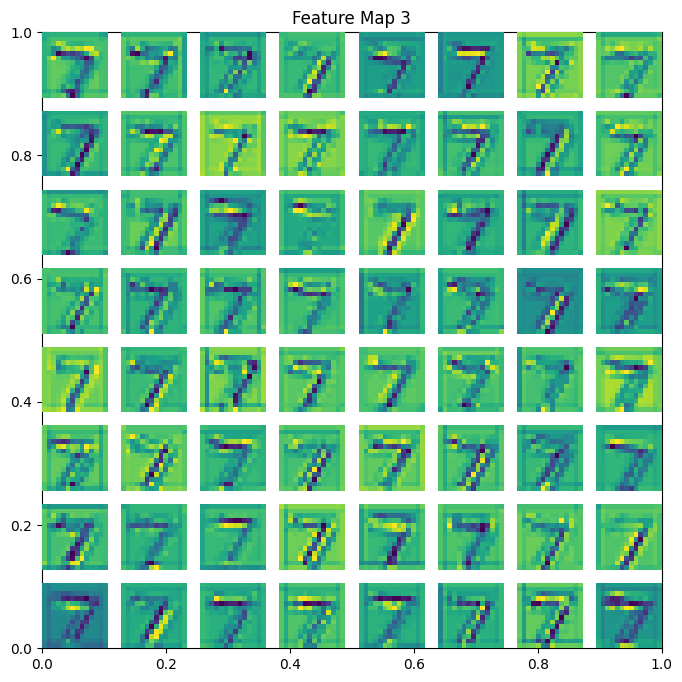

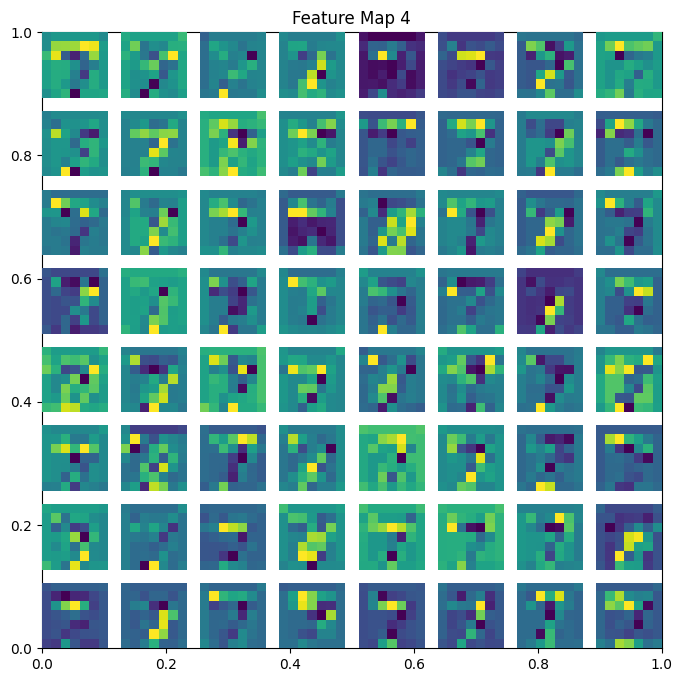

In [10]:
import torch
import matplotlib.pyplot as plt

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.ModuleDict({
            'conv1': nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            'pool1': nn.MaxPool2d(kernel_size=2, stride=2),
            'conv2': nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            'pool2': nn.MaxPool2d(kernel_size=2, stride=2)
        })
        self.classifier = nn.ModuleDict({
            'fc1': nn.Linear(64 * 7 * 7, 100),
            'dropout': nn.Dropout(p=0.4),
            'fc2': nn.Linear(100, 10),
        })

    def forward(self, x):
        feature_maps = []
        for layer in self.features.values():
            x = layer(x)
            feature_maps.append(x)  # 중간 출력을 리스트에 저장
        x = x.reshape(-1, 64 * 7 * 7)
        for layer in self.classifier.values():
            x = layer(x)
        return x  # feature_maps를 빼고 x만 반환

# 모델 인스턴스 생성
model = CNN().to(device)

# 미리 학습된 모델 로드
checkpoint = torch.load('CNN_save.pth')
model.load_state_dict(checkpoint)

# 데이터 로드
images, labels = next(iter(test_loader))
images = images.to(device)

# 추론 모드로 설정
model.eval()

# 입력 이미지에 대한 예측 얻기
with torch.no_grad():
    predictions = model(images)

# 필요한 경우에 feature maps를 따로 사용
with torch.no_grad():
    feature_maps = []
    x = images.clone()  # 원본 이미지를 보존하기 위해 복사
    for layer in model.features.values():
        x = layer(x)
        feature_maps.append(x)

# 필요한 경우에 중간 출력(feature maps) 시각화
for i, feature_map in enumerate(feature_maps):
    plt.figure(figsize=(8, 8))
    plt.title(f"Feature Map {i + 1}")
    for j in range(feature_map.size(1)):
        plt.subplot(8, 8, j + 1)
        plt.imshow(feature_map[0, j].to('cpu').numpy(), cmap='viridis')
        plt.axis('off')
    plt.show()
